In [14]:
%matplotlib inline

import cv2
import numpy as np
import os
import dlib
import matplotlib.pyplot as plt
from imutils.face_utils import FaceAligner

def get_vgg_face_descriptor(input_file, face_detector, face_aligner, vgg_face_net, std=9.411078):
    img = cv2.imread(input_file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    # detect faces
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104, 177, 123))
    face_detector.setInput(blob)
    detections = face_detector.forward()
    if detections[0,0,0,2] < 0.8:
        print('No detected face:', img_name)
        return None
    box = detections[0, 0, 0, 3:7] * [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]
    box = box.astype('int')
    rect = dlib.rectangle(box[0], box[1], box[2], box[3])

    # face alignment
    aligned_face = face_aligner.align(img, img_gray, rect)
    
    # vgg face
    faceBlob = cv2.dnn.blobFromImage(aligned_face, 1.0, (224, 224), (129.1863, 104.7624, 93.5940), swapRB=True, crop=False)    
    vgg_face_net.setInput(faceBlob)
    descriptor = vgg_face_net.forward('fc7')
    descriptor /= std
    return descriptor, aligned_face

In [3]:
# required detectors and networks

# opencv dnn face detector
model_face_detect = {
    "proto": "./models/face_detect/deploy.prototxt.txt",
    "model": "./models/face_detect/res10_300x300_ssd_iter_140000.caffemodel"
}

face_detector = cv2.dnn.readNetFromCaffe(model_face_detect["proto"], model_face_detect["model"])

# dlib face landmark detector
predictor = dlib.shape_predictor('./models/face_landmark/shape_predictor_68_face_landmarks.dat')

# face aligner
fa = FaceAligner(predictor, desiredFaceWidth=256)

# vgg face netowrk
vgg_face = cv2.dnn.readNetFromCaffe('./models/vgg_face/VGG_FACE_deploy.prototxt', './models/vgg_face/VGG_FACE.caffemodel')

In [5]:
# load trained svm
import pickle

with open('./output/svc_vgg_face.model', 'rb') as f:
    svc = pickle.load(f)

people = ['chiao', 'kaze', 'kiki', 'real', 'ricebug', 'tsungchan', 'tsungyu']

chiao


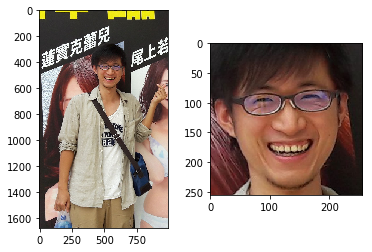

In [43]:
test_file = './images/testing/chiao_01.jpg'
vec, face = get_vgg_face_descriptor(test_file, face_detector, fa, vgg_face)
y = svc.predict(vec)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
print(people[y[0]])

chiao


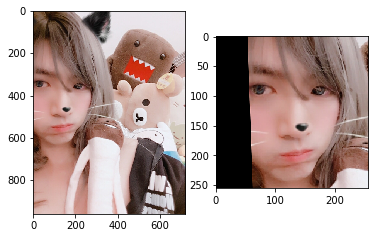

In [44]:
test_file = './images/testing/chiaogirl_01.jpg'
vec, face = get_vgg_face_descriptor(test_file, face_detector, fa, vgg_face)
y = svc.predict(vec)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
print(people[y[0]])

# training images for 'chiao' are all normal images
# but is still to recognize girl version of 'chiao'